# Example of a classification task using RNN

For a similar example, see also:

> NLP FROM SCRATCH: CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN
by Sean Robertson on [pytorch](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)

## Data task
We work on a collection of dates represented with different formats. The task is to associate each date with the correct month, in spite of the date format.

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
data = pd.read_csv('/Users/flint/GitHub/textsent/insights/data/rome_dates.csv', index_col=0)

In [3]:
data.head(20)

,text,target,day,month,year,temperature,temperature_class
0,01-01-1960,1960-01-01,1,1,1960,3.638,1
1,01/01/1960,1960-01-01,1,1,1960,3.638,1
2,01.01.1960,1960-01-01,1,1,1960,3.638,1
3,01/01/1960,1960-01-01,1,1,1960,3.638,1
4,01.01.1960,1960-01-01,1,1,1960,3.638,1
5,"Fri 01, Jan 1960",1960-01-01,1,1,1960,3.638,1
6,"Jan 01, 1960",1960-01-01,1,1,1960,3.638,1
7,"Fri 01, January 1960",1960-01-01,1,1,1960,3.638,1
8,1960/01/01,1960-01-01,1,1,1960,3.638,1
9,1960 January 01,1960-01-01,1,1,1960,3.638,1


### Get a subset of dates with month names

In [4]:
from datetime import datetime

In [5]:
selected_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 
                'October', 'November', 'December']
date_list, month_list, dates_list = data.text.values, data.month.values, data.target.values
dataset = []
for i, d in enumerate(date_list):
    for m in selected_months:
        if m in d:
#            dt = datetime.strptime(dates_list[i], '%Y-%m-%d')
            parts = d.split(m)
            dataset.append(("{}{}".format(parts[0], m), month_list[i]))
            break

In [6]:
dataset[:6]

[('Fri 01, January', 1),
 ('1960 January', 1),
 ('Sat 02, January', 1),
 ('1960 January', 1),
 ('Sun 03, January', 1),
 ('1960 January', 1)]

## Prepare data
In this example, we read each date (text) as a **sequence of chars** represented according to the one-hot encoding scheme.

In [7]:
import string
import torch

### Date strings to PyTorch tensors

In [8]:
alphabet = string.ascii_letters + string.digits + " -./,"

In [9]:
def date2tensor(date_text):
    tensor = torch.zeros(len(date_text), 1, len(alphabet))
    for i, char in enumerate(date_text):
        tensor[i][0][alphabet.find(char)] = 1
    return tensor

def tensor2date(date_tensor):
    return "".join([alphabet[x] for x in torch.nonzero(date_tensor)[:,2]])

#### Example

In [10]:
dt = date2tensor('Sun 03, January')
td = tensor2date(dt)

In [11]:
dt.size()

torch.Size([15, 1, 67])

In [12]:
dt[:2]

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [13]:
td

'Sun 03, January'

## RNN network structure

![rnn](../data/rnn.png)

In [14]:
import torch.nn as nn

In [15]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden):
        combined = torch.cat((input_tensor, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [16]:
hidden_size = 20
rnn = RNN(len(alphabet), hidden_size, len(selected_months))

### Forward step

In [17]:
date_tensor = date2tensor('Sun 03, January')
hidden_tensor = rnn.init_hidden()

In [18]:
hidden_tensor

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [19]:
for row in date_tensor:
    print(hidden_tensor)
    output, next_hidden = rnn(row, hidden_tensor)
    hidden_tensor = next_hidden


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[ 0.0825, -0.1085,  0.1363, -0.0747, -0.0598,  0.0144,  0.0550,  0.0249,
          0.1763,  0.1049,  0.1674,  0.1164, -0.1378, -0.1454, -0.0669, -0.0968,
          0.1491, -0.0699,  0.1035, -0.0516]], grad_fn=<AddmmBackward0>)
tensor([[ 6.7424e-02, -2.7910e-02,  1.1062e-01, -1.0839e-01, -3.6102e-02,
         -1.9075e-02,  8.7800e-02,  2.2504e-02,  1.3163e-01,  2.1337e-01,
          9.9528e-02,  1.3607e-01,  2.7340e-02, -1.1752e-01, -8.7903e-02,
         -2.8534e-02,  1.0355e-01, -1.0969e-01,  2.4327e-02, -2.0353e-04]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.0552,  0.0349,  0.1648, -0.0358, -0.0365,  0.0636,  0.2139,  0.0934,
          0.0612,  0.0257, -0.0047,  0.0639, -0.0343,  0.0233, -0.0414, -0.1130,
          0.0335, -0.0646,  0.1657, -0.0709]], grad_fn=<AddmmBackward0>)
tensor([[-0.0594, -0.1377,  0.1845, -0.0437,  0.0130,  0.0114,  0.1621,  0.0666,
          0.0064,  0.1226, 

In [20]:
np.argmax(output.detach().numpy())

5

In [21]:
output

tensor([[-2.4070, -2.5009, -2.5754, -2.5743, -2.4728, -2.3826, -2.4075, -2.4369,
         -2.5455, -2.5502, -2.4049, -2.5946]], grad_fn=<LogSoftmaxBackward0>)

In [22]:
next_hidden

tensor([[ 0.0249, -0.1473, -0.0350, -0.1075, -0.1006,  0.0002,  0.0174,  0.1886,
          0.1672,  0.1859,  0.1785,  0.0293, -0.1710, -0.1102, -0.0599, -0.0271,
          0.0929, -0.0340,  0.0397, -0.1242]], grad_fn=<AddmmBackward0>)

## Training

In [23]:
def output2month(output):
    top_n, top_i = output.topk(1)
    return selected_months[top_i[0].item()]

In [24]:
output2month(output)

'June'

### Create a training data generator

In [25]:
def create_training():
    date_string, month = dataset[np.random.choice(range(len(dataset)))]
    date_tensor = date2tensor(date_string)
    target_tensor = torch.tensor([month-1], dtype=torch.long)
    return date_tensor, target_tensor, date_string, month

In [26]:
input_t, target, date_string, month = create_training()
print(target, date_string, month)

tensor([9]) 1981 October 10


### Training

In [27]:
loss_function = nn.NLLLoss()
learning_rate = 0.005

In [28]:
def train(target_tensor, date_tensor):
    hidden = rnn.init_hidden()
    rnn.zero_grad()
    for i in range(date_tensor.size()[0]):
        output, hidden = rnn(date_tensor[i], hidden)
    loss = loss_function(output, target_tensor)
    loss.backward()
    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item()

#### Example

In [29]:
date_tensor, target_tensor, date_text, month = create_training()
output, loss = train(target_tensor, date_tensor)

In [30]:
loss

2.586009979248047

In [31]:
print(date_text)
print(tensor2date(date_tensor))
print(output2month(output))

1992 October
1992 October
March


### Training with more data

In [32]:
hidden_size = 128
rnn = RNN(len(alphabet), hidden_size, len(selected_months))

In [33]:
epochs = 3000
error_history = []
run = list(enumerate(range(epochs)))
e = 0
log_period = 50

for i, epoch in tqdm(run):
    date_tensor, target_tensor, date_text, month = create_training()
    output, loss = train(target_tensor, date_tensor)
    e += loss
    if i > 0 and i % log_period == 0:
        error_history.append(e / log_period)
        e = 0

  0%|          | 0/3000 [00:00<?, ?it/s]

#### Plot error rate

In [34]:
import matplotlib.pyplot as plt

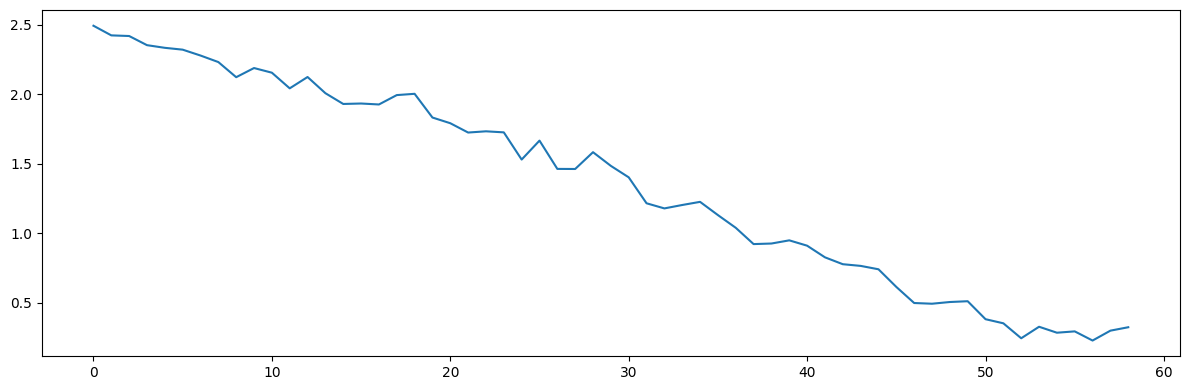

In [35]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(error_history)
plt.tight_layout()
plt.show()

## Test and evaluate

### Test

In [36]:
def predict(date_text):
    hidden = rnn.init_hidden()
    date_tensor = date2tensor(date_text)
    for char_tensor in date_tensor:
        output, hidden = rnn(char_tensor, hidden)
    return output

def output2month(output):
    return int(output.argmax() + 1)

In [37]:
output2month(predict('Tue 27, February'))

2

In [38]:
sample = np.random.choice([x for x, y in dataset], 10)
for d in sample:
    print(d, "month is", output2month(predict(d)))

Fri 14, November month is 12
Fri 13, March month is 3
1983 June month is 6
Tue 29, December month is 12
1999 February month is 2
Mon 12, June month is 6
1980 May month is 5
Thu 15, October month is 10
1963 August month is 8
Sat 06, May month is 5


In [39]:
output2month(predict('Christmass is on December'))

12

In [40]:
output2month(predict('3012 ril'))

4

### Evaluate

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [42]:
y_true, y_pred = [], []
for i in range(2000):
    date_tensor, target_tensor, date_text, month = create_training()
    y_true.append(selected_months[month-1])
    p = output2month(predict(date_text))
    y_pred.append(selected_months[p-1])

In [43]:
print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

       April       1.00      1.00      1.00       140
      August       1.00      1.00      1.00       156
    December       0.48      1.00      0.65       137
    February       1.00      1.00      1.00       130
     January       1.00      1.00      1.00       160
        July       1.00      1.00      1.00       145
        June       1.00      1.00      1.00       135
       March       1.00      1.00      1.00       159
         May       1.00      1.00      1.00       380
    November       1.00      0.02      0.04       153
     October       0.53      1.00      0.69       162
   September       0.00      0.00      0.00       143

    accuracy                           0.85      2000
   macro avg       0.83      0.83      0.78      2000
weighted avg       0.85      0.85      0.81      2000



In [44]:
cm = confusion_matrix(y_true, y_pred, labels=selected_months)

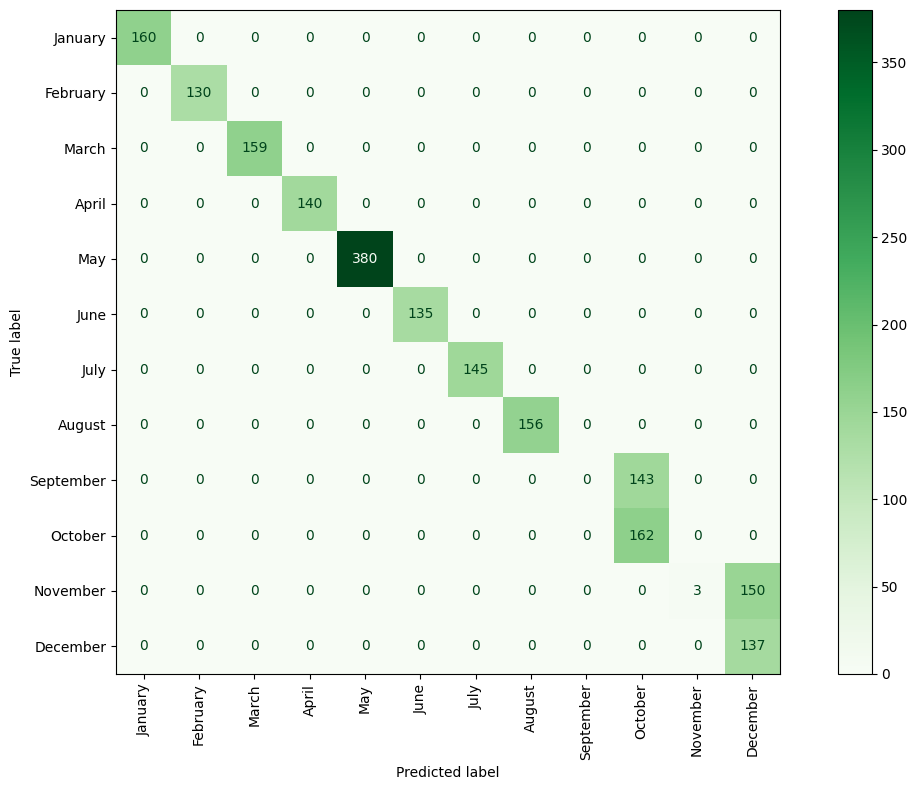

In [45]:
fig, ax = plt.subplots(figsize=(12, 8))
dis = ConfusionMatrixDisplay(cm, display_labels=selected_months)
dis.plot(ax=ax, cmap='Greens', xticks_rotation='vertical')
plt.tight_layout()
plt.show()